### Zelle 1 — Imports & Settings
**Zweck:** Lädt alle Bibliotheken, die du für Datenhandling, Plots und die Modelle brauchst.

**Was passiert:**
- `numpy/pandas`: Daten laden, säubern, transformieren.
- `matplotlib`: einfache, kontrollierbare Plots.
- `sklearn`: robuste Modelle/Validierung (Leave-One-Out), Ridge-Regression und logistische Regression.
- Metriken (`MAE`, `R²`, `AUC`, `Accuracy`) für die Bewertung der Modelle.


In [15]:
################
#   ZELLE 01   #
################

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, accuracy_score


### Zelle 2 — Excel laden (Sheet „Final“), Spalten flatten
**Zweck:** Liest Excel-Auswertung so ein, dass sie in Python stabil weiterverarbeitet werden kann.

**Was passiert:**
- Lädt `Auswertung_Studie.xlsx` aus dem Arbeitsverzeichnis.
- Liest das Tabellenblatt `"Final"` mit einem zweizeiligen Header (`header=[0,1]`).
- „Flacht“ die Multiindex-Spaltennamen ab (z. B. `("Gefühl Sitzposition","Etwas besser")` → `"Gefühl Sitzposition_Etwas besser"`),
  damit du später sauber per Spaltennamen zugreifen kannst.
- Gibt `df.head()` aus, damit du siehst, ob alles korrekt geladen ist.


In [16]:
################
#   ZELLE 02   #
################

excel_path = Path("Auswertung_Studie.xlsx")  # ggf. Pfad anpassen
assert excel_path.exists(), f"Datei nicht gefunden: {excel_path.resolve()}"

df_raw = pd.read_excel(excel_path, sheet_name="Final", header=[0, 1])

def flatten_cols(cols):
    out = []
    for a, b in cols:
        a = "" if "Unnamed" in str(a) else str(a).strip()
        b = "" if "Unnamed" in str(b) else str(b).strip()
        name = "_".join([x for x in (a, b) if x])
        out.append(name)
    return out

df = df_raw.copy()
df.columns = flatten_cols(df.columns)

df.head(20)


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Nutzung Methode_Einstellung durch Laden / Mechaniker,Nutzung Methode_Augenmaß / Gefühl,Nutzung Methode_Hüfte,Gefühl Sitzposition_Deutlich schlechter,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls
0,25,00:00:35.910000,67.7,157.3,27,x,NaN,164,75.5,70.0,...,NaN,x,NaN,NaN,x,NaN,NaN,NaN,7,1
1,24,00:00:57.040000,68.2,143.1,26,NaN,x,200,92.0,80.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,1
2,23,00:01:10.400000,75.4,150.6,23,x,NaN,166,79.6,63.5,...,NaN,x,x,NaN,x,NaN,NaN,NaN,2,9
3,22,00:01:15.850000,72.4,161.0,23,x,NaN,172,82.9,71.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,9,1
4,21,00:02:19.390000,76.2,160.7,26,x,NaN,178,87.0,76.0,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0
5,20,00:01:39.560000,86.4,148.6,26,NaN,x,193,92.0,77.0,...,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,10,0
6,19,00:01:14.580000,70.8,156.0,21,NaN,x,186,88.0,75.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,2
7,18,00:02:56.150000,76.6,143.2,26,NaN,x,194,91.0,75.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,8,4
8,17,00:02:17.640000,72.6,144.5,27,NaN,x,180,82.0,70.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0
9,16,00:01:46.760000,81.3,147.4,23,x,NaN,193,88.0,80.5,...,NaN,x,NaN,NaN,NaN,x,NaN,NaN,10,0


### Zelle 3 — Basis-Cleaning (Probanden 1–5 optional raus, x→1, NaN→0, Zeit→Sekunden)
**Zweck:** Bringt Rohdaten in ein numerisch auswertbares Format.

**Was passiert:**
- Entfernt Zeilen ohne Probanden-ID.
- Entfernt optional Probanden 1–5 (wie in deinem bisherigen Workflow).
- Ersetzt fehlende Werte (`NaN`) durch 0 und `"x"` durch 1 (typisch für Dummy-Spalten).
- Wandelt die Spalte `"Ben. Zeit"` (falls vorhanden) in Sekunden um (Timedelta → Sekunden).
- Versucht alle Spalten numerisch zu interpretieren (wo möglich), um spätere Modelle nicht zu blockieren.
- Zeigt am Ende Form und erste Zeilen.


In [17]:
################
#   ZELLE 03   #
################


# nur echte Datensätze behalten
df = df[df["Proband Nr."].notna()].copy()

# optional: Probanden 1-5 entfernen (wie in deinem bisherigen Notebook)
# df = df[~df["Proband Nr."].between(1, 5)].copy()

# 1) 'x' -> 1 (nur wo es vorkommt)
df = df.replace({"x": 1})

# 2) nur object-Spalten versuchen zu numerifizieren (ohne errors="ignore")
obj_cols = [c for c in df.columns if c != "Proband Nr." and df[c].dtype == "object"]
for c in obj_cols:
    try:
        df[c] = pd.to_numeric(df[c])
    except (ValueError, TypeError):
        # bleibt Text, falls wirklich Text vorhanden ist
        pass

# 3) Ben. Zeit (falls vorhanden) robust in Sekunden umrechnen
if "Ben. Zeit" in df.columns:
    df["Ben. Zeit"] = pd.to_timedelta(df["Ben. Zeit"].astype(str), errors="coerce").dt.total_seconds()

# 4) fehlende Werte auffüllen (nach Konvertierung!)
df = df.fillna(0)

# optional: falls pandas noch object dtypes hat, sauber inferieren
df = df.infer_objects(copy=False)

df.shape
df.head(3)


C:\Users\mweiler\AppData\Local\Temp\ipykernel_25092\346951193.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"x": 1})


,Proband Nr.,Ben. Zeit,Kniewinkel 1,Kniewinkel 2,Alter,Geschlecht_weiblich,Geschlecht_männlich,Größe,Beininnenlänge,Sitzhöhe,...,Nutzung Methode_Einstellung durch Laden / Mechaniker,Nutzung Methode_Augenmaß / Gefühl,Nutzung Methode_Hüfte,Gefühl Sitzposition_Deutlich schlechter,Gefühl Sitzposition_Etwas schlechter,Gefühl Sitzposition_Kein Unterschied,Gefühl Sitzposition_Etwas besser,Gefühl Sitzposition_Deutlich besser,Längerer Zeitraum,Veränderungsimpuls
0,25,35.91,67.7,157.3,27,1.0,0.0,164,75.5,70.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7,1
1,24,57.04,68.2,143.1,26,0.0,1.0,200,92.0,80.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8,1
2,23,70.40,75.4,150.6,23,1.0,0.0,166,79.6,63.5,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2,9


### Zelle 4 — Spalten bereinigen (konstante/leer-Spalten raus)
**Zweck:** Entfernt Spalten, die keine Information tragen (und Modelle/Statistik nur stören).

**Was passiert:**
- Sucht numerische Spalten, die nur einen einzigen Wert haben (z. B. überall 0).
- Entfernt diese „konstanten“ Spalten.
- Druckt, welche Spalten rausfliegen, und wie viele Spalten/Zeilen übrig bleiben.


In [18]:
################
#   ZELLE 04   #
################


# Konstanten/All-0/All-NaN raus (sonst stören sie Modelle & Screening)
numeric_cols = df.select_dtypes(include="number").columns
const_cols = [c for c in numeric_cols if df[c].nunique(dropna=False) <= 1]
df = df.drop(columns=const_cols)

print("Entfernte konstante Spalten:", const_cols)
print("Übrig:", df.shape)


Entfernte konstante Spalten: ['Satteleinstellung, wer_Freunde / Familie', 'Satteleinstellung, wer_Professioneller Fitter', 'Satteleinstellung, wer_Sonstige', 'Nutzung Methode_Einstellung durch Laden / Mechaniker', 'Gefühl Sitzposition_Deutlich schlechter']
Übrig: (25, 51)


### Zelle 5 — Outcome-Variablen: Distanz zum Ziel + mehrere Optimum-Fenster (Sensitivität)
**Zweck:** Definiert deine Zielgröße so, dass du sie sinnvoll modellieren kannst – trotz kleinem n.

**Was passiert:**
- Legt einen Zielwert fest (`TARGET = 152.5` als Mitte von 150–155°).
- Definiert mehrere „optimal“-Fenster (z. B. 150–155, 145–155, 145–160), um Sensitivität zu prüfen.
- Erstellt Haupt-Outcome `AbsDev_Target = |Kniewinkel2 - TARGET|`:
  - je kleiner, desto „näher am Optimum“ (und analytisch viel stabiler als ja/nein bei wenigen Treffern).
- Erstellt für jedes Fenster:
  - `In_window`: 1 wenn Kniewinkel2 im Fenster, sonst 0
  - `WinDev_window`: signierte Abweichung (0 im Fenster, negativ unterhalb, positiv oberhalb)
  - `AbsWinDev_window`: absolute Abweichung zum Fenster
- Gibt eine kleine Vorschau aus.


In [19]:
################
#   ZELLE 05   #
################


# Zielwert (Mitte des 150–155 Fensters)
TARGET = 152.5

# mehrere Fenster, damit du Sensitivität berichten kannst
WINDOWS = {
    "w150_155": (150.0, 155.0),
    "w145_155": (145.0, 155.0),
    "w145_160": (145.0, 160.0),
}

# Haupt-Outcomes
df["AbsDev_Target"] = (df["Kniewinkel 2"] - TARGET).abs()

# Abweichung zum Fenster (0 wenn drin, sonst Distanz zum nächsten Rand, mit Vorzeichen optional)
def window_deviation(x, lo, hi):
    # signed deviation to nearest boundary (0 inside)
    if x < lo: return x - lo
    if x > hi: return x - hi
    return 0.0

for key, (lo, hi) in WINDOWS.items():
    df[f"In_{key}"] = ((df["Kniewinkel 2"] >= lo) & (df["Kniewinkel 2"] <= hi)).astype(int)
    df[f"WinDev_{key}"] = df["Kniewinkel 2"].apply(lambda v: window_deviation(v, lo, hi))
    df[f"AbsWinDev_{key}"] = df[f"WinDev_{key}"].abs()

df[["Kniewinkel 2", "AbsDev_Target"] + [f"In_{k}" for k in WINDOWS]].head()


,Kniewinkel 2,AbsDev_Target,In_w150_155,In_w145_155,In_w145_160
0,157.3,4.8,0,0,1
1,143.1,9.4,0,0,0
2,150.6,1.9,1,1,1
3,161.0,8.5,0,0,0
4,160.7,8.2,0,0,0


### Zelle 6 — Feature-Engineering (km/Woche & Gefühl-Skala, plus Sitzhöhen-Ratio)
**Zweck:** Reduziert Dummy-Explosion und baut interpretierbare, „starke“ Features.

**Was passiert:**
- Wandelt `km/Woche_*` Dummies in einen ordinalen Code (1..4) um und löscht die Dummies.
- Wandelt `Gefühl Sitzposition_*` Dummies in eine Skala (-2..2) um und löscht die Dummies.
- Baut `Sitzhoehe_rel = Sitzhöhe / Beininnenlänge` (falls beide existieren):
  - relative Größen sind oft robuster als absolute Werte.
- Zählt Methoden:
  - `n_Methods_known` = Anzahl „Methode bekannt_*“ aktiv
  - `n_Methods_used` = Anzahl „Nutzung Methode_*“ aktiv
  - Falls `"Methode bekannt_keine"` vorhanden ist, setzt es die Known-Anzahl auf 0.
- Ausgabe: nur die neue DataFrame-Form (Dimensionalität prüfen).


In [20]:
################
#   ZELLE 06   #
################


# km/Woche one-hot -> Code 1..4 (falls noch vorhanden)
km_cols = ['km/Woche_<20', 'km/Woche_21-40', 'km/Woche_41-60', 'km/Woche_>60']
if all(c in df.columns for c in km_cols):
    weights = np.array([1, 2, 3, 4])
    df["km/Woche_Code"] = df[km_cols].to_numpy().dot(weights)
    df.drop(columns=km_cols, inplace=True)

# Gefühl Sitzposition one-hot -> -2..2 (falls noch vorhanden)
feel_cols = [
    'Gefühl Sitzposition_Deutlich schlechter',
    'Gefühl Sitzposition_Etwas schlechter',
    'Gefühl Sitzposition_Kein Unterschied',
    'Gefühl Sitzposition_Etwas besser',
    'Gefühl Sitzposition_Deutlich besser'
]
if all(c in df.columns for c in feel_cols):
    weights = np.array([-2, -1, 0, 1, 2])
    df["Gefühl_Sitzposition_Skala"] = df[feel_cols].to_numpy().dot(weights)
    df.drop(columns=feel_cols, inplace=True)

# Sitzhöhe relativ zur Beinlänge (wenn beide vorhanden) – oft viel aussagekräftiger als absolute Werte
if "Sitzhöhe" in df.columns and "Beininnenlänge" in df.columns:
    df["Sitzhoehe_rel"] = df["Sitzhöhe"] / df["Beininnenlänge"]

# Methoden-Counts (bekannt/genutzt) – reduziert Dimension & macht Effekte stabiler
known_cols = [c for c in df.columns if c.startswith("Methode bekannt_")]
use_cols   = [c for c in df.columns if c.startswith("Nutzung Methode_")]

if known_cols:
    df["n_Methods_known"] = df[known_cols].sum(axis=1)
    # falls "keine" existiert: dann ist count = 0
    if "Methode bekannt_keine" in df.columns:
        df.loc[df["Methode bekannt_keine"] == 1, "n_Methods_known"] = 0

if use_cols:
    df["n_Methods_used"] = df[use_cols].sum(axis=1)

df.shape


(25, 61)

### Zelle 7 — Quick Descriptives + zentrale Plots
**Zweck:** Schneller Realität-Check: Verteilungen, Klassenbalance, offensichtliche Trends.

**Was passiert:**
- Druckt n, Summary-Statistiken von Kniewinkel2 und AbsDev.
- Druckt für jedes Fenster: wie viele Probanden „drin“ sind.
- Plottet Histogramm von Kniewinkel2 und zeichnet die Fenstergrenzen ein.
- Falls `Sitzhoehe_rel` existiert: Scatterplot Sitzhöhe_rel vs Kniewinkel2,
  um grobe Abhängigkeiten sofort zu sehen.


n = 25
       Kniewinkel 2  AbsDev_Target
count     25.000000      25.000000
mean     151.240000       6.068000
std        6.837641       3.170531
min      139.200000       1.500000
25%      147.200000       3.900000
50%      149.600000       5.100000
75%      157.200000       8.200000
max      162.100000      13.300000
w150_155 : 3 / 25
w145_155 : 11 / 25
w145_160 : 16 / 25


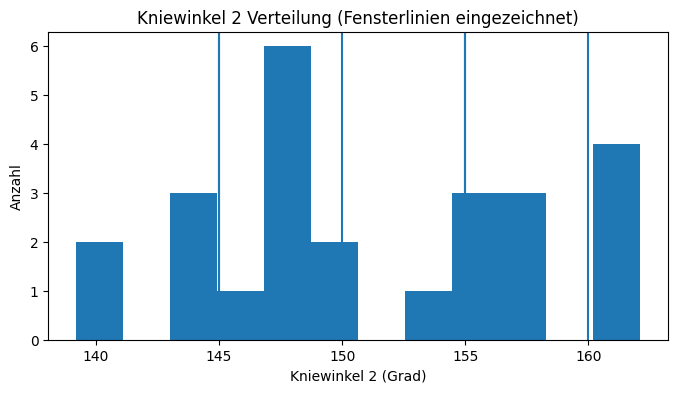

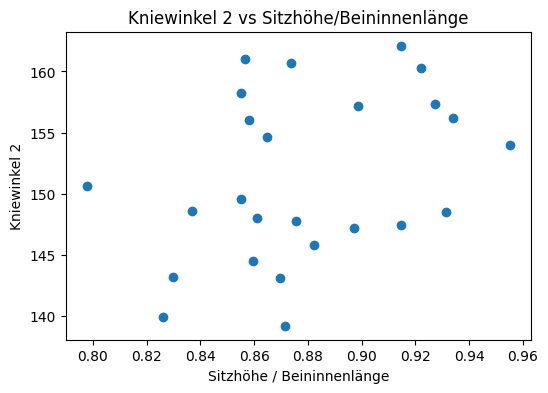

In [21]:
################
#   ZELLE 07   #
################


n = len(df)
print("n =", n)
print(df[["Kniewinkel 2", "AbsDev_Target"]].describe())

for key in WINDOWS:
    print(key, ":", int(df[f"In_{key}"].sum()), "/", n)

# Verteilung Kniewinkel 2 + Fenster
plt.figure(figsize=(8,4))
plt.hist(df["Kniewinkel 2"], bins=12)
for key,(lo,hi) in WINDOWS.items():
    plt.axvline(lo)
    plt.axvline(hi)
plt.title("Kniewinkel 2 Verteilung (Fensterlinien eingezeichnet)")
plt.xlabel("Kniewinkel 2 (Grad)")
plt.ylabel("Anzahl")
plt.show()

# Kniewinkel vs Sitzhoehe_rel (falls vorhanden)
if "Sitzhoehe_rel" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df["Sitzhoehe_rel"], df["Kniewinkel 2"])
    plt.title("Kniewinkel 2 vs Sitzhöhe/Beininnenlänge")
    plt.xlabel("Sitzhöhe / Beininnenlänge")
    plt.ylabel("Kniewinkel 2")
    plt.show()


### Zelle 8 — Univariates Screening (robust): Variablen vs AbsDev_Target
**Zweck:** Findet Kandidatenfaktoren, die mit „näher am Optimum“ zusammenhängen — ohne zu overfitting.

**Was passiert:**
- Definiert Hilfsfunktionen:
  - `bootstrap_ci`: Bootstrap-Konfidenzintervalle (stabiler bei kleinem n).
  - `spearman_r`: Spearman-Korrelation (robust für ordinale/monotone Zusammenhänge).
- `screen_predictors` prüft jede numerische Variable:
  - Wenn binär (0/1): Effekt = Median(AbsDev | x=1) - Median(AbsDev | x=0)
    - **negativ** bedeutet: Gruppe mit x=1 ist im Median näher am Ziel.
    - CI per Bootstrap über Zeilenresampling.
  - Wenn kontinuierlich: Spearman r zwischen x und AbsDev + Bootstrap-CI.
- Schließt Outcomes/IDs aus (damit du nicht „gegen dich selbst“ korrelierst).
- Ergebnis ist eine Rangliste (`screen_absdev`) nach Stärke des Effekts.


In [22]:
################
#   ZELLE 08   #
################


def bootstrap_ci(values, stat_fn, n_boot=4000, seed=0):
    rng = np.random.default_rng(seed)
    vals = np.asarray(values)
    boots = []
    for _ in range(n_boot):
        samp = rng.choice(vals, size=len(vals), replace=True)
        boots.append(stat_fn(samp))
    boots = np.sort(boots)
    return float(boots[int(0.025*n_boot)]), float(boots[int(0.975*n_boot)])

def spearman_r(x, y):
    # Spearman über Ranks
    xr = pd.Series(x).rank().to_numpy()
    yr = pd.Series(y).rank().to_numpy()
    if np.std(xr) == 0 or np.std(yr) == 0:
        return np.nan
    return float(np.corrcoef(xr, yr)[0,1])

def screen_predictors(df, y_col, exclude_cols=None, min_group=3):
    if exclude_cols is None: exclude_cols = []
    y = df[y_col].astype(float).to_numpy()

    rows = []
    for c in df.columns:
        if c in exclude_cols or c == y_col:
            continue
        if c == "Proband Nr.":
            continue
        if c not in df.select_dtypes(include="number").columns:
            continue

        x = df[c].astype(float).to_numpy()
        uniq = np.unique(x[~np.isnan(x)])
        if len(uniq) <= 1:
            continue

        # binär?
        if set(uniq).issubset({0.0, 1.0}):
            g1 = y[x == 1]
            g0 = y[x == 0]
            if len(g1) < min_group or len(g0) < min_group:
                continue
            # Effekt: Median-Differenz (1 - 0); negativ = Gruppe(1) näher am Ziel (bei AbsDev)
            eff = float(np.median(g1) - np.median(g0))

            # Bootstrap CI über Resampling der gesamten Zeilen (robust)
            idx = np.arange(len(df))
            def stat_fn(sample_idx):
                sx = x[sample_idx]; sy = y[sample_idx]
                g1s = sy[sx == 1]; g0s = sy[sx == 0]
                if len(g1s)==0 or len(g0s)==0:
                    return np.nan
                return float(np.median(g1s) - np.median(g0s))
            ci_lo, ci_hi = bootstrap_ci(idx, stat_fn, n_boot=2500, seed=1)

            rows.append({"var": c, "type": "binary", "effect": eff, "ci_lo": ci_lo, "ci_hi": ci_hi,
                         "n1": int((x==1).sum()), "n0": int((x==0).sum())})

        else:
            # kontinuierlich -> Spearman
            r = spearman_r(x, y)

            idx = np.arange(len(df))
            def stat_fn(sample_idx):
                return spearman_r(x[sample_idx], y[sample_idx])
            ci_lo, ci_hi = bootstrap_ci(idx, stat_fn, n_boot=2500, seed=2)

            rows.append({"var": c, "type": "continuous", "effect": r, "ci_lo": ci_lo, "ci_hi": ci_hi,
                         "n1": np.nan, "n0": np.nan})

    out = pd.DataFrame(rows)
    out["abs_effect"] = out["effect"].abs()
    out = out.sort_values("abs_effect", ascending=False).reset_index(drop=True)
    return out

exclude = [
    "Kniewinkel 1", "Kniewinkel 2",
    "AbsDev_Target",
] + [f"In_{k}" for k in WINDOWS] + [f"WinDev_{k}" for k in WINDOWS] + [f"AbsWinDev_{k}" for k in WINDOWS]

screen_absdev = screen_predictors(df, "AbsDev_Target", exclude_cols=exclude)
screen_absdev.head(20)


,var,type,effect,ci_lo,ci_hi,n1,n0,abs_effect
0,Form der Fahrradnutzung_Beides,binary,4.600000,0.200000,6.250000,7.0,18.0,4.600000
1,Gefühl Sitzposition_Kein Unterschied,binary,3.300000,-0.800000,4.800000,11.0,14.0,3.300000
2,Methode bekannt_keine,binary,2.750000,-0.400000,4.700000,6.0,19.0,2.750000
3,Nutzung Methode_Augenmaß / Gefühl,binary,2.300000,0.800000,5.400000,20.0,5.0,2.300000
4,Gefühl Sitzposition_Etwas schlechter,binary,-1.950000,-4.000000,1.800000,12.0,13.0,1.950000
5,Methode bekannt_Hüfte,binary,-1.800000,-5.900000,NaN,3.0,22.0,1.800000
6,Form der Fahrradnutzung_Gelegentlich/Kein rege...,binary,-1.000000,-5.100000,3.700000,4.0,21.0,1.000000
7,Form der Fahrradnutzung_Sport / Training,binary,-1.000000,-4.600000,2.500000,5.0,20.0,1.000000
8,Fahrradtyp_City/Commuter,binary,0.800000,-2.750000,4.500000,12.0,13.0,0.800000
9,Geschlecht_männlich,binary,-0.700000,-3.850000,3.200000,19.0,6.0,0.700000


### Zelle 9 — Top-Effekte visualisieren (Forest-Plot-ähnlich)
**Zweck:** Macht die wichtigsten Effekte aus Zelle 8 visuell und leicht interpretierbar.

**Was passiert:**
- Nimmt die Top-N Variablen aus `screen_absdev`.
- Plottet pro Variable:
  - Punkt = Effekt
  - Linie = Bootstrap-CI (Unsicherheit)
- Vertikale Linie bei 0: kein Effekt.
- Wichtig: Bei `AbsDev_Target` heißt **Effekt < 0** meist „besser/ näher am Ziel“.


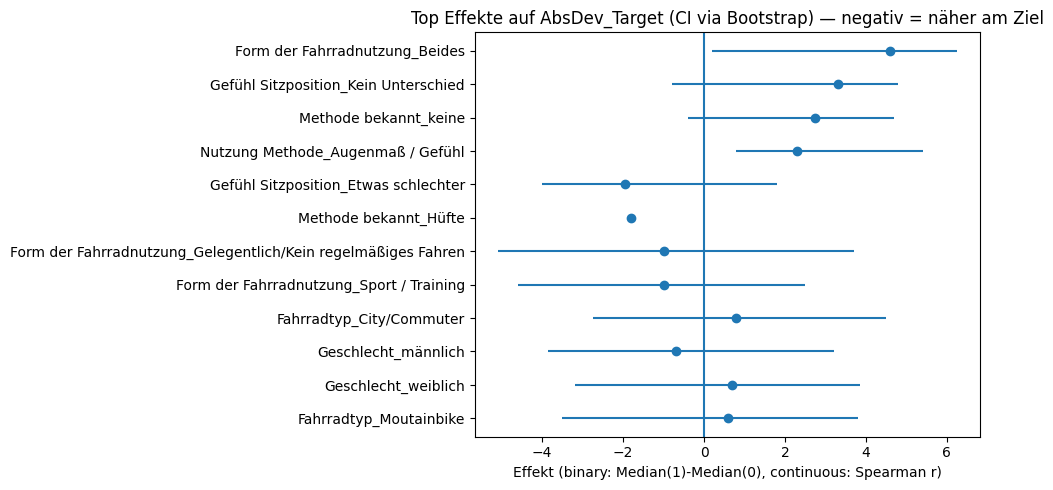

In [23]:
################
#   ZELLE 09   #
################


topn = 12
top = screen_absdev.head(topn).copy()

plt.figure(figsize=(10, 5))
ypos = np.arange(len(top))[::-1]
plt.hlines(y=ypos, xmin=top["ci_lo"], xmax=top["ci_hi"])
plt.plot(top["effect"], ypos, "o")
plt.yticks(ypos, top["var"])
plt.axvline(0)
plt.title("Top Effekte auf AbsDev_Target (CI via Bootstrap) — negativ = näher am Ziel")
plt.xlabel("Effekt (binary: Median(1)-Median(0), continuous: Spearman r)")
plt.tight_layout()
plt.show()


### Zelle 10 — Konfundierung raus: Residualisieren (Körpermaße/Sitzhöhe) + Screening
**Zweck:** Trennt „Biomechanik/Anthropometrie“ von „Umfragefaktoren“ (Methoden, Erfahrung, etc.).

**Was passiert:**
- Wählt Basisfeatures aus den vorhandenen Spalten: Sitzhöhe, Beininnenlänge, Größe, Alter (was da ist).
- Fit eines Ridge-Modells: `Kniewinkel2 ~ Basisfeatures`
  - Ridge stabilisiert bei kleinen Stichproben und korrelierten Inputs.
- Erstellt Residuen: `Knee2_resid = Kniewinkel2 - Vorhersage`
  - Residuen = das, was **nicht** durch Körpermaße/Sitzhöhe erklärt wird.
- Screeningt dann erneut wie in Zelle 8, aber jetzt mit `Knee2_resid` als Outcome,
  um Effekte zu finden, die über Anthropometrie hinausgehen.


In [24]:
################
#   ZELLE 10   #
################


# Basis-Modell: Kniewinkel 2 ~ (Sitzhöhe, Beininnenlänge, Größe, Alter) soweit vorhanden
base_feats = [c for c in ["Sitzhöhe", "Beininnenlänge", "Größe", "Alter"] if c in df.columns]
assert len(base_feats) >= 1, "Keine Basis-Features gefunden (Sitzhöhe/Beininnenlänge/Größe/Alter)."

X_base = df[base_feats].astype(float).to_numpy()
y_knee = df["Kniewinkel 2"].astype(float).to_numpy()

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 50), cv=LeaveOneOut(), scoring="neg_mean_squared_error"))
])
pipe.fit(X_base, y_knee)
y_pred = pipe.predict(X_base)
df["Knee2_resid"] = y_knee - y_pred

print("Basis-Features:", base_feats)
print("R2 (in-sample, nur zur Orientierung):", r2_score(y_knee, y_pred))

# Residuum als neues Outcome: was bleibt übrig, nachdem Körpermaße/Sitzhöhe erklärt sind?
exclude_resid = exclude + base_feats + ["Knee2_resid"]
screen_resid = screen_predictors(df, "Knee2_resid", exclude_cols=exclude_resid)
screen_resid.head(20)


Basis-Features: ['Sitzhöhe', 'Beininnenlänge', 'Größe', 'Alter']
R2 (in-sample, nur zur Orientierung): 0.5667817680558698


,var,type,effect,ci_lo,ci_hi,n1,n0,abs_effect
0,Gefühl Sitzposition_Etwas schlechter,binary,-6.255729,-9.296200,-0.208574,12.0,13.0,6.255729
1,Form der Fahrradnutzung_Gelegentlich/Kein rege...,binary,5.397787,-1.553708,8.493987,4.0,21.0,5.397787
2,Fahrradtyp_Gravelbike,binary,-4.238547,-7.567502,0.997789,4.0,21.0,4.238547
3,Methode bekannt_Hüfte,binary,4.184167,-1.678564,NaN,3.0,22.0,4.184167
4,Gefühl Sitzposition_Kein Unterschied,binary,3.739408,-1.296337,9.072595,11.0,14.0,3.739408
5,Methode bekannt_Kniewinkel,binary,-2.782173,-8.029053,2.961267,11.0,14.0,2.782173
6,Fahrradtyp_Rennard,binary,-2.511185,-8.829346,3.072497,6.0,19.0,2.511185
7,Form der Fahrradnutzung_Beides,binary,-2.498651,-7.849965,3.850861,7.0,18.0,2.498651
8,Methode bekannt_keine,binary,2.375527,-4.083454,8.573875,6.0,19.0,2.375527
9,Nutzung Methode_Augenmaß / Gefühl,binary,1.404434,-6.944717,5.146256,20.0,5.0,1.404434


### Zelle 11 — Multivariat: Ridge-Modell für AbsDev_Target (LOOCV) + Koeffizienten
**Zweck:** Schaut, ob mehrere Faktoren *gemeinsam* AbsDev vorhersagen — und wie gut das generalisiert.

**Was passiert:**
- Baut Feature-Matrix X aus numerischen Spalten (ohne Outcomes/IDs).
- Nutzt Leave-One-Out Cross Validation (LOOCV):
  - Jede Person wird einmal „Test“, Rest „Train“ → gut bei kleinem n.
- `cross_val_predict` erzeugt LOOCV-Vorhersagen für jede Person.
- Bewertet Vorhersage:
  - `MAE`: mittlerer absoluter Fehler (in Grad)
  - `R²`: Anteil erklärter Varianz (kann bei kleinem n auch negativ sein)
- Fit auf allen Daten NUR, um Koeffizienten zu inspizieren:
  - große |coef| = Variable ist im multivariaten Modell wichtig (Interpretation vorsichtig!).


In [25]:
################
#   ZELLE 11   #
################


# Feature-Set: alles numerisch, aber ohne Outcomes/IDs
drop_cols = ["Proband Nr.", "Kniewinkel 1", "Kniewinkel 2", "AbsDev_Target", "Knee2_resid"] \
            + [f"In_{k}" for k in WINDOWS] + [f"WinDev_{k}" for k in WINDOWS] + [f"AbsWinDev_{k}" for k in WINDOWS]

feat_cols = [c for c in df.select_dtypes(include="number").columns if c not in drop_cols]
X = df[feat_cols].astype(float).to_numpy()
y = df["AbsDev_Target"].astype(float).to_numpy()

model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 60), cv=LeaveOneOut(), scoring="neg_mean_absolute_error"))
])

# LOOCV Vorhersagen (ehrlicher als in-sample)
loo = LeaveOneOut()
y_hat = cross_val_predict(model, X, y, cv=loo)

print("LOOCV MAE:", mean_absolute_error(y, y_hat))
print("LOOCV R2 :", r2_score(y, y_hat))

# Fit auf allen Daten nur um Koeffizienten anzuschauen
model.fit(X, y)
coefs = model.named_steps["ridge"].coef_
coef_df = pd.DataFrame({"feature": feat_cols, "coef": coefs}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
coef_df.head(25)


LOOCV MAE: 3.1369112063339735
LOOCV R2 : -0.3844353822774853


,feature,coef
11,Form der Fahrradnutzung_Beides,0.263886
36,Nutzung Methode_Augenmaß / Gefühl,0.261464
7,Dauer aktives Radfahren,0.245325
40,Gefühl Sitzposition_Etwas besser,-0.184029
10,Form der Fahrradnutzung_Sport / Training,-0.182357
35,Nutzung Methode_Kniewinkel,-0.166104
5,Beininnenlänge,0.147566
37,Nutzung Methode_Hüfte,-0.147527
4,Größe,0.131468
19,Fahrradtyp_Trecking,-0.130524


### Zelle 12 — Klassifikation „im Fenster“ (Standard: 145–155), LOOCV AUC/Accuracy
**Zweck:** Alternativer Blick: „im (realistischeren) Optimalfenster ja/nein“.

**Was passiert:**
- Nimmt als Ziel `In_w145_155` (meist besser balanciert als 150–155 bei dir).
- Trainiert eine L2-logistische Regression (stabil, wenig Overfitting).
- LOOCV liefert für jede Person eine vorhergesagte Wahrscheinlichkeit.
- Bewertet:
  - `AUC`: wie gut das Modell Rangordnung trennt (unabhängig vom Schwellenwert).
  - `Accuracy`: Trefferquote bei Schwelle 0.5 (bei Unbalance mit Vorsicht).
- Fit auf allen Daten, um Koeffizienten zu sehen:
  - Vorzeichen zeigt Richtung (mehr Wahrscheinlichkeit „im Fenster“).


In [26]:
################
#   ZELLE 12   #
################


# Hinweis: 150–155 ist bei dir extrem unausgewogen (nur 2/20). Daher als Standard: 145–155.
ybin = df["In_w145_155"].astype(int).to_numpy()

# LogReg mit L2 (stabil), LOOCV-Predictions
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=1.0,
        l1_ratio=0.0,     # == L2
        solver="liblinear",
        max_iter=5000
    ))
])

proba = cross_val_predict(clf, X, ybin, cv=loo, method="predict_proba")[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Class balance (1=im Fenster):", int(ybin.sum()), "/", len(ybin))
print("LOOCV AUC     :", roc_auc_score(ybin, proba))
print("LOOCV Accuracy:", accuracy_score(ybin, pred))

# Fit auf allen Daten, um Koeffizienten zu sehen (Interpretation vorsichtig!)
clf.fit(X, ybin)
logreg = clf.named_steps["logreg"]
coef = logreg.coef_.ravel()
coef_df_bin = pd.DataFrame({"feature": feat_cols, "coef": coef}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
coef_df_bin.head(25)


Class balance (1=im Fenster): 11 / 25
LOOCV AUC     : 0.1948051948051948
LOOCV Accuracy: 0.28


,feature,coef
11,Form der Fahrradnutzung_Beides,-0.694860
0,Ben. Zeit,-0.688637
36,Nutzung Methode_Augenmaß / Gefühl,-0.609321
26,Zuverlässigkeit,-0.572126
40,Gefühl Sitzposition_Etwas besser,0.556516
21,Fahrradtyp_Sonstige,-0.532243
13,Form der Fahrradnutzung_Sonstiges,0.526900
24,"Satteleinstellung, wer_Ich selbst",0.516063
15,Fahrradtyp_Gravelbike,0.504043
7,Dauer aktives Radfahren,-0.461881


### Zelle 13 — Sensitivität: mehrere Fenster vergleichen
**Zweck:** Zeigt, ob deine Aussagen vom gewählten „optimal“-Fenster abhängen.

**Was passiert:**
- Wiederholt die Klassifikationsbewertung (AUC/Accuracy) für jedes Fenster.
- Wenn ein Fenster zu wenige 1er oder 0er hat (<5), wird es als „nicht sinnvoll“ markiert (NaN),
  weil die Bewertung dann extrem instabil wird.
- Ergebnis: Tabelle mit `window`, `n1`, `auc`, `acc`.


In [27]:
################
#   ZELLE 13   #
################


results = []
for key in WINDOWS.keys():
    ybin_k = df[f"In_{key}"].astype(int).to_numpy()
    # wenn zu wenige "1", macht Klassifikation wenig Sinn
    if ybin_k.sum() < 5 or (len(ybin_k) - ybin_k.sum()) < 5:
        results.append({"window": key, "n1": int(ybin_k.sum()), "auc": np.nan, "acc": np.nan})
        continue

    proba_k = cross_val_predict(clf, X, ybin_k, cv=loo, method="predict_proba")[:, 1]
    pred_k  = (proba_k >= 0.5).astype(int)
    results.append({
        "window": key,
        "n1": int(ybin_k.sum()),
        "auc": float(roc_auc_score(ybin_k, proba_k)),
        "acc": float(accuracy_score(ybin_k, pred_k))
    })

pd.DataFrame(results)


,window,n1,auc,acc
0,w150_155,3,NaN,NaN
1,w145_155,11,0.194805,0.28
2,w145_160,16,0.618056,0.68


### Zelle 14 — Export: Rankings + Koeffizienten speichern
**Zweck:** Macht deine Analyse reproducible: Ergebnisse liegen als CSV vor (für Bericht/Anhang).

**Was passiert:**
- Erstellt Ordner `results_out`.
- Speichert:
  - `screen_absdev.csv`: univariate Effekte auf AbsDev_Target
  - `screen_residual.csv`: univariate Effekte auf Residuen (nach Basis-Adjustierung)
  - `ridge_absdev_coefs.csv`: multivariate Ridge-Koeffizienten
  - `logreg_inwindow_coefs.csv`: logistische Koeffizienten
- Druckt den Speicherpfad.


In [28]:
################
#   ZELLE 14   #
################


out_dir = Path("results_out")
out_dir.mkdir(exist_ok=True)

screen_absdev.to_csv(out_dir / "screen_absdev.csv", index=False)
screen_resid.to_csv(out_dir / "screen_residual.csv", index=False)
coef_df.to_csv(out_dir / "ridge_absdev_coefs.csv", index=False)
coef_df_bin.to_csv(out_dir / "logreg_inwindow_coefs.csv", index=False)

print("Gespeichert in:", out_dir.resolve())



Gespeichert in: C:\Users\mweiler\Documents\GitHub\MMI_Tool\results_out


## Interpretation der Ergebnisse (explorativ)

### Datengrundlage
Nach Datenbereinigung (Probanden 1–5 ausgeschlossen) umfasst die Stichprobe **n = 20**.

**Kniewinkel 2** liegt in dieser Stichprobe bei:
- Mittelwert **151.57°**, Median **149.6°**, Spannweite **139.2° bis 162.1°**.
- Die Abweichung zur Zielmitte **152.5°** (definiert als `AbsDev_Target = |Kniewinkel2 − 152.5|`) beträgt:
  Median **4.95°**, Mittelwert **6.01°**, Minimum **1.9°**, Maximum **13.3°**.

Die Anzahl der Personen im „optimalen“ Bereich hängt stark von der Fensterdefinition ab:
- **150–155°:** **2/20**
- **145–155°:** **8/20**
- **145–160°:** **13/20**

**Wichtige Konsequenz:** Das enge Fenster 150–155° ist in den Daten so selten besetzt, dass Ursachen dafür statistisch nur sehr eingeschränkt identifiziert werden können. Aussagen sind daher primär **explorativ** (Hypothesengenerierung).

---

### Univariate Zusammenhänge: Welche Faktoren hängen mit „näher am Zielwinkel“ zusammen?
Als Hauptzielgröße wird `AbsDev_Target` verwendet (kleiner = näher an der Zielmitte).  
Für binäre Variablen ist der Effekt definiert als:  
**Median(AbsDev | x=1) − Median(AbsDev | x=0)**  
→ **negativ** bedeutet: Gruppe mit x=1 liegt im Median näher am Ziel.

**Auffällige Muster in den univariaten Ergebnissen (`screen_absdev.csv`):**
- **Nutzung „Augenmaß/Gefühl“ als Methode** ist mit **größerer Abweichung** vom Zielwinkel assoziiert  
  (Median-Differenz ca. **+1.55°**; Bootstrap-CI liegt in der Auswertung oberhalb von 0).  
  → In dieser Stichprobe wirkt die reine subjektive Einstellung tendenziell **weniger nahe am Zielbereich**.
- **„Keine Methode bekannt“** zeigt ebenfalls **größere Abweichung**  
  (Median-Differenz ca. **+3.50°**).  
  → Plausibel, aber wegen kleiner Gruppengröße (n≈5) vorsichtig zu interpretieren.
- **„Sport + Alltag“ als Nutzungsprofil** weist eine **größere Abweichung** auf  
  (Median-Differenz ca. **+3.95°**).  
  → Interpretierbar als Kompromiss-Setup, aber statistisch unsicher (CI schneidet 0).
- **„Gefühl Sitzposition: Etwas schlechter“** ist in den Daten mit **geringerer Abweichung** verbunden  
  (Median-Differenz ca. **−3.30°**).  
  → Inhaltlich spannend (möglicherweise „objektiver“ eingestellt, fühlt sich ungewohnt an), aber ebenfalls unsicher (CI schneidet 0).

Ein weiterer Hinweis aus der univariaten Analyse ist, dass **längere Dauer aktiven Radfahrens** tendenziell mit **größerer Abweichung** einhergeht (Spearman r ca. **+0.47**).  
Dies könnte bedeuten, dass erfahrenere Personen eher nach Komfort/Leistung/Disziplin einstellen statt nach einem festen Zielwinkel. Auch dies ist aufgrund kleiner Stichprobe vorsichtig zu interpretieren.

---

### Blick auf „im Fenster“ (145–155°) als anschauliche Ergänzung
Für das Fenster **145–155°** liegen **8/20** Personen im Bereich. In dieser Gruppe treten in den Daten häufiger auf:
- **Fersenmethode** genutzt/bekannt (Anteil im Fenster höher als außerhalb),
- **„Augenmaß/Gefühl“** genutzt ist im Fenster seltener als außerhalb,
- **„keine Methode bekannt“** ist im Fenster seltener als außerhalb.

**Interpretation:** Insgesamt zeigt sich als konsistentes Muster, dass **konkretere/objektivere Methoden** (z. B. Fersenmethode) eher mit „im Bereich“ zusammenhängen, während **rein subjektive Einstellung** (Augenmaß/Gefühl) eher mit „außerhalb“ zusammenhängt. Aufgrund der kleinen Gruppengrößen bleibt dies jedoch ein **Hinweis** und keine belastbare Kausal-Aussage.

---

### Residual-Analyse (nach Körpermaßen/Sitzhöhe) – vorsichtig interpretieren
In `screen_residual.csv` werden Effekte auf das Residuum von Kniewinkel2 nach einem Basismodell (Körpermaße/Sitzhöhe/Alter) betrachtet. Die Muster deuten u. a. an, dass Nutzungsprofile (z. B. Gravel/Sport) systematisch in Richtung „mehr Flexion“ bzw. „mehr Streckung“ vom erwarteten Wert abweichen könnten.

**Limitation:** Die interne Validierung des RidgeCV-Setups kann bei Leave-One-Out (Testgröße 1) numerisch problematisch sein, wodurch Residuen und Effekte nicht als „hart“ statistisch abgesichert gelten. Diese Ergebnisse sind daher besonders als **explorative Richtungsindikatoren** zu verstehen.

---

### Multivariate Modelle (Ridge/LogReg) liefern keine stabile Generalisierung
Die multivariaten Modelle zeigen in Leave-One-Out-Validierung keine überzeugende Vorhersageleistung:
- Ridge für `AbsDev_Target`: **LOOCV R² negativ**, Modell nicht besser als einfache Baseline.
- LogReg für „im Fenster“ (145–155°): **Accuracy und AUC** deutlich schlechter als triviale Baselines.

**Konsequenz:** Die Koeffizienten aus den multivariaten Modellen sollten in dieser Stichprobe **nicht** als belastbare Effekte interpretiert werden. Die Daten reichen (bei n=20 und vielen Prädiktoren) eher für **explorative Muster** als für stabile multivariate Erklärmodelle.

---

### Fazit
- Der Anteil im engen Zielbereich 150–155° ist sehr gering (**2/20**), daher sind „Ursachen“ dafür schwer belastbar zu identifizieren.
- Univariate Ergebnisse liefern Hinweise, dass **subjektive Methoden (Augenmaß/Gefühl)** mit einer **größeren Abweichung** vom Zielwinkel einhergehen, während **konkretere Methoden** eher mit „näher am Ziel“ zusammenhängen.
- Multivariate Modelle generalisieren in dieser Stichprobe nicht stabil; die Analyse dient daher primär der **Hypothesengenerierung** und sollte mit größerer Stichprobe oder reduzierten Prädiktoren repliziert werden.
